In [1]:
import sys
sys.path.append('../src')

In [2]:
from gso.manifolds import AlgebraicManifold
from gso.graph_sampling import GraphSampler
from gso.signal_generation import SignalGenerator
from gso.gso_learning import GraphLaplacianEstimator, GraphLaplacianEstimatorBis

In [3]:
import networkx as nx
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import csr_matrix
import csv

In [4]:
def create_sbm(sizes: list, probs: list, seed=None) -> csr_matrix:
    g = nx.stochastic_block_model(sizes, probs, seed=seed)
    return nx.adjacency_matrix(g).tocsr()

sizes = [33, 33, 33]
probs = np.array([[0.3, 0.01, 0.02],
                  [0.01, 0.25, 0.03],
                  [0.02, 0.03, 0.2]])
A = create_sbm(sizes, probs)

In [5]:
num_equations = 2
num_variables = 4
max_degree = 4
seed = 22

M = AlgebraicManifold(num_equations, num_variables, max_degree, seed)

L, W, point_cloud, epsilon = GraphSampler().create_weighted_graph_from_structure(M, A)
L_dense = L.toarray()
np.fill_diagonal(L_dense, 0)

In [6]:
errors = []
x = []
adjacency = A.toarray()
print(repr(adjacency))

for i in range(3, 22):
    n_samples = 2**i
    x.append(n_samples)
    print("Generating", n_samples, "samples")

    X = SignalGenerator().generate_gaussian_signal(L, n_samples, method="SG")

    # sic_estimator = GraphLaplacianEstimatorBis(method='sic', tol=1e-5, max_iter=5000).fit(X)
    # error_sic = np.linalg.norm(L_dense - sic_estimator.laplacian, ord='fro')
    # print("   SIC (Lasso) done")    

    if n_samples > 99:
        alpha = 0.0
    else:
        alpha = 1e-10
    ggl_estimator = GraphLaplacianEstimatorBis(method='ggl', alpha=alpha, tol=1e-10).fit(X)
    # print(ggl_estimator.L)
    error_ggl = np.linalg.norm(L_dense - ggl_estimator.laplacian, ord='fro')
    print("   GGL done")
    
    # masked_ggl_estimator = GraphLaplacianEstimatorBis(method='ggl', tol=1e-16).fit(X, A_mask=adjacency)
    # error_ggl_mask = np.linalg.norm(L_dense - masked_ggl_estimator.laplacian, ord='fro')
    # print("   GGL with mask done")
    
    # TODO: implement MCP and debug Lasso (or signals)
    
    errors.append(error_ggl)

with open('ggl_errors_by_sample_size.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['n_samples', 'error_ggl'])
    for n, e_ggl in zip(x, errors):
        writer.writerow([n, e_ggl])

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(99, 99))
Generating 8 samples
   GGL done
Generating 16 samples
   GGL done
Generating 32 samples
   GGL done
Generating 64 samples
   GGL done
Generating 128 samples
   GGL done
Generating 256 samples
   GGL done
Generating 512 samples
   GGL done
Generating 1024 samples
   GGL done
Generating 2048 samples
   GGL done
Generating 4096 samples
   GGL done
Generating 8192 samples
   GGL done
Generating 16384 samples
   GGL done
Generating 32768 samples
   GGL done
Generating 65536 samples
   GGL done
Generating 131072 samples
   GGL done
Generating 262144 samples
   GGL done
Generating 524288 samples
   GGL done
Generating 1048576 samples
   GGL done
Generating 2097152 samples
   GGL done


In [ ]:
errors = []
x = []
adjacency = A.toarray()
print(repr(adjacency))

for i in range(3, 22):
    n_samples = 2**i
    x.append(n_samples)
    print("Generating", n_samples, "samples")

    X = SignalGenerator().generate_gaussian_signal(L, n_samples, method="SG")

    # sic_estimator = GraphLaplacianEstimatorBis(method='sic', tol=1e-5, max_iter=5000).fit(X)
    # error_sic = np.linalg.norm(L_dense - sic_estimator.laplacian, ord='fro')
    # print("   SIC (Lasso) done")    

    if n_samples > 99:
        alpha = 0.0
    else:
        alpha = 1e-10
    ggl_estimator = GraphLaplacianEstimatorBis(method='ggl', alpha=alpha, tol=1e-10).fit(X)
    # print(ggl_estimator.L)
    error_ggl = np.linalg.norm(L_dense - ggl_estimator.laplacian, ord='fro')
    print("   GGL done")
    
    # masked_ggl_estimator = GraphLaplacianEstimatorBis(method='ggl', tol=1e-16).fit(X, A_mask=adjacency)
    # error_ggl_mask = np.linalg.norm(L_dense - masked_ggl_estimator.laplacian, ord='fro')
    # print("   GGL with mask done")
    
    # TODO: implement MCP and debug Lasso (or signals)
    
    errors.append(error_ggl)

with open('ggl_errors_by_sample_size.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['n_samples', 'error_ggl'])
    for n, e_ggl in zip(x, errors):
        writer.writerow([n, e_ggl])

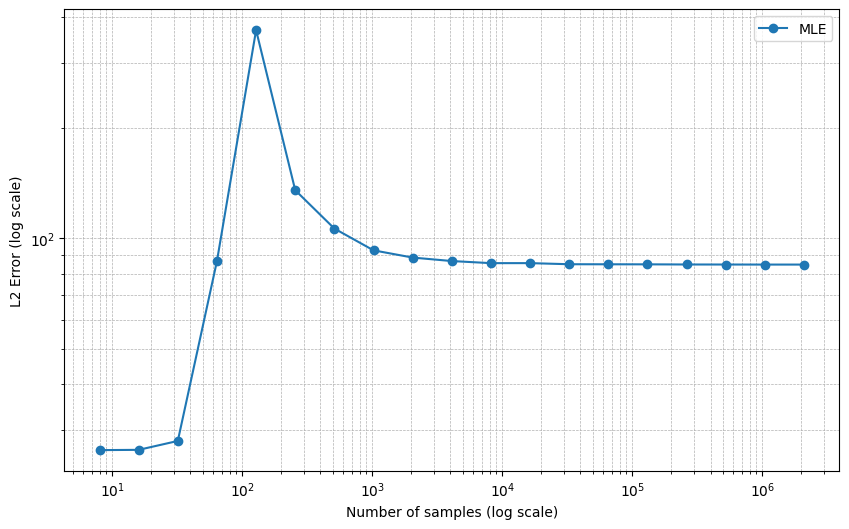

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(x, errors, marker='o', linestyle='-', label='MLE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of samples (log scale)')
plt.ylabel('L2 Error (log scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()

In [12]:
times = []
x = []

probs = np.array([[0.3, 0.01, 0.02],
                  [0.01, 0.25, 0.03],
                  [0.02, 0.03, 0.2]])

for i in range(4, 10):
    n_nodes = 3**i
    x.append(n_nodes)
    
    print(n_nodes)
    
    sizes = [n_nodes//3, n_nodes//3, n_nodes//3]
    A = create_sbm(sizes, probs)
    L, W, point_cloud, epsilon = GraphSampler().create_weighted_graph_from_structure(M, A)
    X = SignalGenerator().generate_gaussian_signal(L, int(10000000), method="SG")

    start_time = time.perf_counter()
    ggl_estimator = GraphLaplacianEstimatorBis(method='ggl').fit(X)
    elapsed = time.perf_counter() - start_time
    
    times.append(elapsed)

with open('ggl_times_by_num_nodes.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['n_nodes', 'time'])
    for n, t in zip(x, times):
        writer.writerow([n, t])

81


RuntimeError: Optimization failed: ABNORMAL: 

ValueError: x and y must have same first dimension, but have shapes (3,) and (19,)

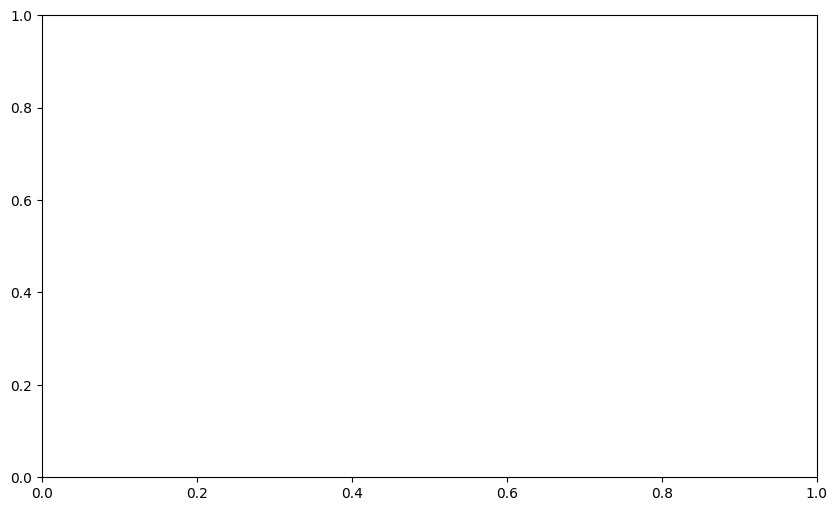

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(x, errors, marker='o', linestyle='-', label='MLE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of samples (log scale)')
plt.ylabel('L2 Error (log scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()